In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

import sys
sys.path.append("..")

In [2]:
# Load social categories (Guilbeault and SO-B-IT Taxonomies)
from lexical_data.sobit_taxonomy import sobit_taxonomy

sobit_categories = list(sorted(set.union(*[set(v) for v in sobit_taxonomy.values()])))
guilbeault_categories = []
with open("../lexical_data/guilbeault_social_categories.txt", "r") as f:
    for line in f:
        guilbeault_categories.append(line.strip())

combined = guilbeault_categories + sobit_categories

In [3]:
import os
from collections import defaultdict

# Load LAION-400M word counts
path_to_word_identity_counts = "analysis_data/clip_bias_transfer/"
word_identity_counts_global = defaultdict(lambda: defaultdict(int))

for file in os.listdir(path_to_word_identity_counts):
    if not file.endswith(".json"):
        continue

    if not file.startswith("word_identity_counts_"):
        continue

    with open(os.path.join(path_to_word_identity_counts, file), "r") as f:
        word_identity_counts = json.load(f)

    for word, identity_counts in word_identity_counts.items():
        for identity, count in identity_counts.items():
            word_identity_counts_global[word][identity] += count

word_identity_counts_global = dict({identity: dict(identity_counts) for identity, identity_counts in word_identity_counts_global.items()})

In [4]:
dataset_bias_guilbeault = []
dataset_bias_sobit = []
dataset_bias_combined = []

for word, word_counts in word_identity_counts_global.items():
    male_count, female_count = word_counts.get("male", 0), word_counts.get("female", 0)
    total_count = male_count + female_count
    if total_count < 100:
        continue
    
    male_ratio = male_count / total_count
    female_ratio = female_count / total_count
    word_bias = female_ratio - male_ratio

    dataset_bias_combined.append(
        {
            "word": word,
            "bias": word_bias
        }
    )

    if word in guilbeault_categories:
        dataset_bias_guilbeault.append(
            {
                "word": word,
                "bias": word_bias
            }
        )
    if word in sobit_categories:
        dataset_bias_sobit.append(
            {
                "word": word,
                "bias": word_bias
            }
        )

dataset_bias_guilbeault = pd.DataFrame(dataset_bias_guilbeault)
dataset_bias_sobit = pd.DataFrame(dataset_bias_sobit)
dataset_bias_combined = pd.DataFrame(dataset_bias_combined)

In [5]:
from collections import defaultdict
import torch

model_bias = []
path_to_clip_scores = "../results/clip_scores"

model_bias_by_dataset = dict()

for dataset in os.listdir(path_to_clip_scores):
    if dataset == "race" or dataset == "test":
        continue
    
    for categories_name in os.listdir(os.path.join(path_to_clip_scores, dataset)):
        if categories_name == "combined":
            dataset_bias_df = dataset_bias_combined
            category_words = guilbeault_categories + sobit_categories
        elif categories_name == "guilbeault":
            dataset_bias_df = dataset_bias_guilbeault
            category_words = guilbeault_categories
        elif categories_name == "sobit":
            dataset_bias_df = dataset_bias_sobit
            category_words = sobit_categories
        else:
            raise ValueError(f"Invalid categories name: {categories_name}")
        
        valid_words = set(dataset_bias_df["word"].tolist())
        is_valid_word = [word in valid_words for word in category_words]
        
        for model in os.listdir(os.path.join(path_to_clip_scores, dataset, categories_name)):
            path_to_model = os.path.join(path_to_clip_scores, dataset, categories_name, model)
            for variant in os.listdir(path_to_model):
                print(f"Processing {dataset} {categories_name} {model} {variant}")
                path_to_variant = os.path.join(path_to_model, variant)
                metadata = pd.read_csv(os.path.join(path_to_variant, "metadata.csv"))
                genders = metadata["gender"].tolist()

                is_male = [gender == "male" for gender in genders]
                is_female = [gender == "female" for gender in genders]
            
                image_embeddings = np.load(os.path.join(path_to_variant, "image_embeddings.npy"))
                try:
                    text_embeddings = np.load(os.path.join(path_to_variant, "text_embeddings.npy"))
                except:
                    text_embeddings = np.load(os.path.join(path_to_variant, "text_only", "text_embeddings.npy"))

                image_embeddings = torch.from_numpy(image_embeddings).float().cuda()
                text_embeddings = torch.from_numpy(text_embeddings).float().cuda()

                # Normalize image embeddings
                image_embeddings = image_embeddings / image_embeddings.norm(dim=1, keepdim=True)
                text_embeddings = text_embeddings / text_embeddings.norm(dim=1, keepdim=True)

                # Compute cosine similarities
                cosine_similarities = image_embeddings @ text_embeddings
                cosine_similarities = cosine_similarities[:, is_valid_word]
                normalizer = cosine_similarities.flatten().std()

                # Compute bias
                male_similarities = cosine_similarities[is_male].mean(axis=0)
                female_similarities = cosine_similarities[is_female].mean(axis=0)
                model_bias = (female_similarities - male_similarities) / normalizer

                dataset_bias_dict = dict(zip(dataset_bias_df["word"].tolist(), dataset_bias_df["bias"].tolist()))

                bias_df = pd.DataFrame(
                    {
                        "word": [word for word in category_words if word in valid_words],
                        "model": model_bias.cpu().numpy(),
                        "data": [dataset_bias_dict[word] for word in category_words if word in valid_words]
                    }
                )

                model_bias_by_dataset[(model + "/" + variant, dataset, categories_name)] = bias_df

Processing causalface guilbeault EVA01-g-14 laion400m_s11b_b41k
Processing causalface guilbeault ViT-B-32 laion400m_e32
Processing causalface guilbeault ViT-B-32 laion400m_e31
Processing causalface guilbeault ViT-B-16-plus-240 laion400m_e32
Processing causalface guilbeault ViT-B-16-plus-240 laion400m_e31
Processing causalface guilbeault convnext_base laion400m_s13b_b51k
Processing causalface guilbeault ViT-L-14 laion400m_e32
Processing causalface guilbeault ViT-L-14 laion400m_e31
Processing causalface guilbeault ViT-B-16 laion400m_e32
Processing causalface guilbeault ViT-B-16 laion400m_e31
Processing causalface guilbeault ViT-B-32-quickgelu laion400m_e32
Processing causalface guilbeault ViT-B-32-quickgelu laion400m_e31
Processing causalface sobit ViT-L-14 laion400m_e32
Processing causalface sobit ViT-L-14 laion400m_e31
Processing causalface sobit ViT-B-16-plus-240 laion400m_e32
Processing causalface sobit ViT-B-16-plus-240 laion400m_e31
Processing causalface sobit ViT-B-32 laion400m_e3

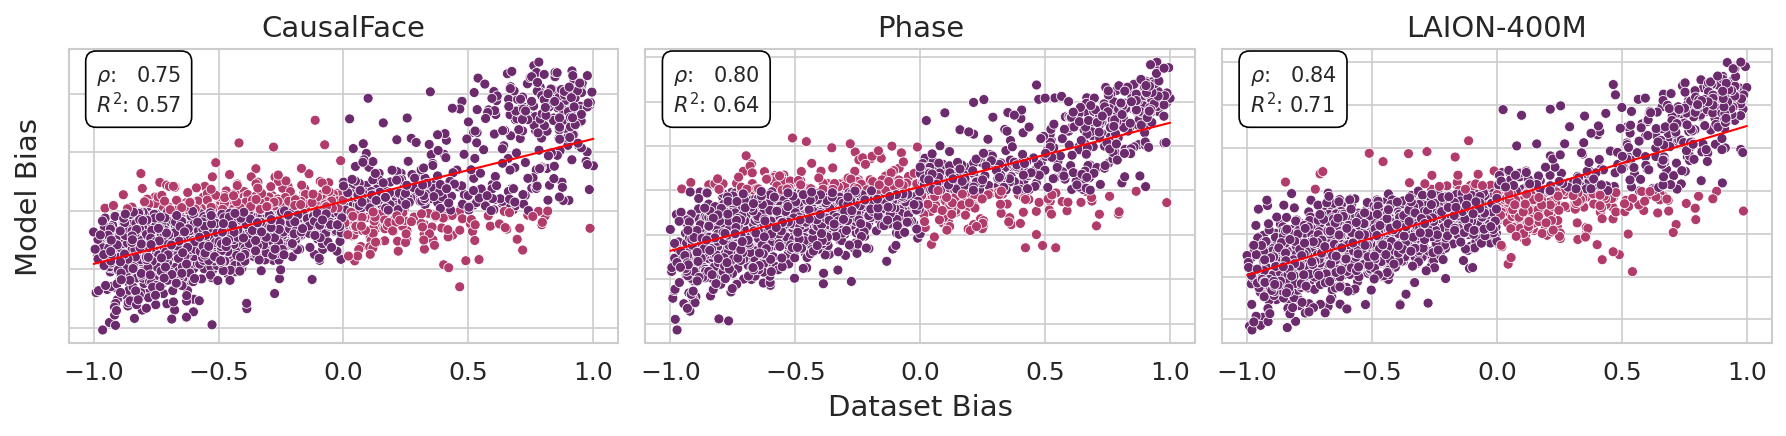

In [7]:
model = 'ViT-B-32-quickgelu/laion400m_e32'
categories = 'guilbeault'

palette = sns.color_palette("flare")
palette = [palette[3], palette[5]]

df_gender = model_bias_by_dataset[(model, "gender", categories)]
df_phase = model_bias_by_dataset[(model, "phase", categories)]
df_causalface = model_bias_by_dataset[(model, "causalface", categories)]

for df in [df_gender, df_phase, df_causalface]:
    signs = [np.sign(model) * np.sign(data) for model, data in zip(df["model"].tolist(), df["data"].tolist())]
    signs = [1 if sign >= 0 else -1 for sign in signs]
    df["group"] = signs


from scipy.stats import pearsonr
from sklearn.metrics import r2_score

sns.set_context("paper")
sns.set_style("whitegrid")

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 3), dpi=150, tight_layout=True, sharex=True)

sns.scatterplot(data=df_causalface, x="data", y="model", hue="group", ax=ax1, legend=False, palette=palette)
sns.scatterplot(data=df_phase, x="data", y="model", hue="group", ax=ax2, legend=False, palette=palette)
sns.scatterplot(data=df_gender, x="data", y="model", hue="group", ax=ax3, legend=False, palette=palette)

#ax1.set_ylim(-3.5, 3.5)
#ax2.set_ylim(-3.5, 3.5)

ax1.set_title("CausalFace", fontsize=14)
ax2.set_title("Phase", fontsize=14)
ax3.set_title("LAION-400M", fontsize=14)

ax1.set_xlabel("")
ax2.set_xlabel("Dataset Bias", fontsize=14)
ax3.set_xlabel("")

ax1.set_ylabel("Model Bias", fontsize=14)
ax2.set_ylabel("")
ax3.set_ylabel("")

ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])

ax1.set_xticks(ax1.get_xticks())
ax2.set_xticks(ax2.get_xticks())
ax3.set_xticks(ax3.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=12)
ax3.set_xticklabels(ax3.get_xticklabels(), fontsize=12)

for i, (ax, df) in enumerate(zip([ax1, ax2, ax3], [df_causalface, df_phase, df_gender])):
    data, model = np.array(df["data"].tolist()), np.array(df["model"].tolist())
    rho = pearsonr(data, model)
    slope, intercept = np.polyfit(data, model, 1)
    model_pred = slope * data + intercept
    df["model_pred"] = model_pred
    r2 = r2_score(model, model_pred)

    min_axis, max_axis = -1, 1

    ax.plot(
        [min_axis, max_axis],
        [slope * min_axis + intercept, slope * max_axis + intercept],
        color="red",
        linestyle="-",
        linewidth=1
    )
    
    top_pos = slope * max_axis + intercept
    ax.text(
        0.05, 0.95, f"$\\rho$:   {rho[0]:.2f}\n$R^2$: {r2:.2f}",
        fontsize=10, ha="left", va="top", transform=ax.transAxes,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
    )

os.makedirs("figures", exist_ok=True)
plt.savefig("figures/first_order_bias_clip_gender.pdf", dpi=300, bbox_inches="tight", format="pdf")
plt.show()

In [8]:
import os
from collections import defaultdict

path_to_sd_results = "analysis_data/sd_bias_transfer/stable-diffusion/"
sd_models = ["stable-diffusion-v1-1", "stable-diffusion-v1-4"]

# Load Stable Diffusion Prompts
with open("../lexical_data/stable_diffusion_prompts.txt", "r") as f:
    stable_diffusion_prompts = [line.strip() for line in f.readlines()]

stable_diffusion_prompts = [prompt.replace("a photo of", "").strip() for prompt in stable_diffusion_prompts]
stable_diffusion_prompts = [" ".join(prompt.split()[1:]) for prompt in stable_diffusion_prompts if prompt]


def get_sd_bias_transfer(model: str, categories_name: str):
    results_records = []
    num_skipped = 0
    categories = sobit_categories if categories_name == "sobit" else guilbeault_categories

    word_gender_ratios = defaultdict(dict)

    for word, gender_counts in word_identity_counts_global.items():
        male_count = gender_counts.get("male", 0)
        female_count = gender_counts.get("female", 0)
        total_count = max(1, male_count + female_count)
        if total_count < 100:
            continue
    
        word_gender_ratios[word]["male"] = male_count / total_count
        word_gender_ratios[word]["female"] = female_count / total_count

    for i, prompt in enumerate(stable_diffusion_prompts):
        if not (prompt in categories or f"{prompt} person" in categories):
            num_skipped += 1
            continue

        with open(os.path.join(path_to_sd_results, model, "metas", f"{i}.json"), "r") as mf:
            metadata = json.load(mf)
            if len(metadata) < 50:
                num_skipped += 1
                continue
            
            gender_distribution = defaultdict(int)
            for element in metadata:
                gender = element["answer"]
                gender_distribution[gender] += 1
            
            male_count = gender_distribution["male"]
            female_count = gender_distribution["female"]
            total_count = max(1, male_count + female_count)

            model_bias = female_count / total_count
            dataset_bias = word_gender_ratios[prompt].get("female", None)

            results_records.append({
                "prompt": prompt,
                "model": model_bias,
                "data": dataset_bias
            })

    results_df = pd.DataFrame(results_records).dropna()
    results_df["group"] = [
        1 if np.sign(results_df.iloc[i]["data"] - 0.5) == np.sign(results_df.iloc[i]["model"] - 0.5) else -1
        for i in range(len(results_df))
    ]

    return results_df

In [9]:
df_stablediffusion11 = get_sd_bias_transfer("stable-diffusion-v1-1", "guilbeault")
df_stablediffusion14 = get_sd_bias_transfer("stable-diffusion-v1-4", "guilbeault")

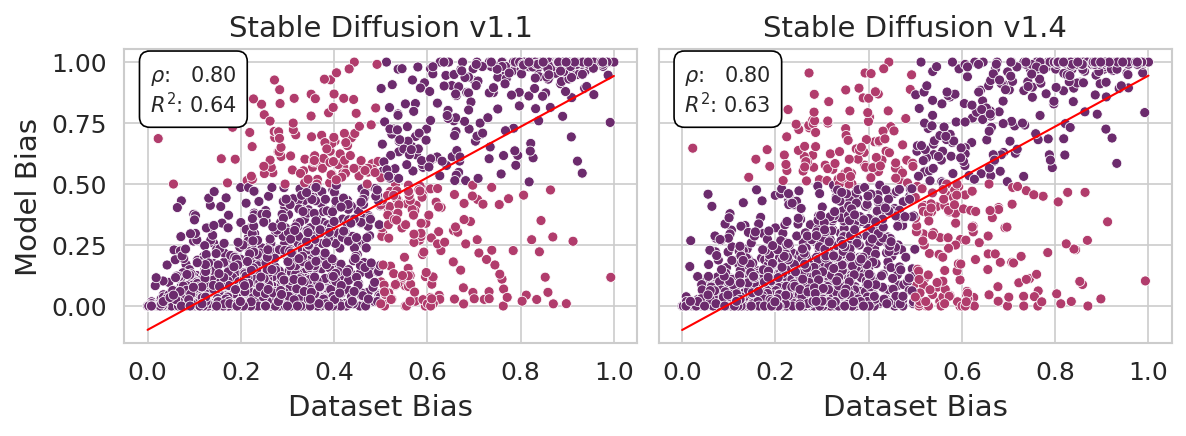

In [10]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

sns.set_context("paper")
sns.set_style("whitegrid")

palette = sns.color_palette("flare")
palette = [palette[3], palette[5]]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 3), dpi=150, tight_layout=True, sharex=True, sharey=True)

sns.scatterplot(data=df_stablediffusion11, x="data", y="model", hue="group", ax=ax1, legend=False, palette=palette)
sns.scatterplot(data=df_stablediffusion14, x="data", y="model", hue="group", ax=ax2, legend=False, palette=palette)

#ax1.set_ylim(-3.5, 3.5)
#ax2.set_ylim(-3.5, 3.5)

ax1.set_title("Stable Diffusion v1.1", fontsize=14)
ax2.set_title("Stable Diffusion v1.4", fontsize=14)

ax1.set_xlabel("Dataset Bias", fontsize=14)
ax2.set_xlabel("Dataset Bias", fontsize=14)

ax1.set_ylabel("Model Bias", fontsize=14)
ax2.set_ylabel("Model Bias", fontsize=14)

ax1.set_xticks(ax1.get_xticks())
ax2.set_xticks(ax2.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=12)

ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax1.set_yticklabels(["0.00", "0.25", "0.50", "0.75", "1.00"], fontsize=12)
ax2.set_yticklabels(["0.00", "0.25", "0.50", "0.75", "1.00"], fontsize=12)

for i, (ax, df) in enumerate(zip([ax1, ax2], [df_stablediffusion11, df_stablediffusion14])):
    data, model = np.array(df["data"].tolist()), np.array(df["model"].tolist())
    rho = pearsonr(data, model)
    slope, intercept = np.polyfit(data, model, 1)
    model_pred = slope * data + intercept
    df["model_pred"] = model_pred
    r2 = r2_score(model, model_pred)

    min_axis, max_axis = 0, 1

    ax.plot(
        [min_axis, max_axis],
        [slope * min_axis + intercept, slope * max_axis + intercept],
        color="red",
        linestyle="-",
        linewidth=1
    )
    
    top_pos = slope * max_axis + intercept
    ax.text(
        0.05, 0.95, f"$\\rho$:   {rho[0]:.2f}\n$R^2$: {r2:.2f}",
        fontsize=10, ha="left", va="top", transform=ax.transAxes,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
    )

os.makedirs("figures", exist_ok=True)
plt.savefig("figures/first_order_bias_sd_gender.pdf", dpi=300, bbox_inches="tight", format="pdf")
plt.show()

In [11]:
r2_scores_records = []

dataset_rename = {
    "gender": "LAION-400M",
    "phase": "Phase",
    "causalface": "CausalFace"
}

categories_rename = {
    "guilbeault": "Guilbeault",
    "sobit": "SO-B-IT"
}

for (model, dataset, categories_name), df in model_bias_by_dataset.items():
    data, model = np.array(df["data"].tolist()), np.array(df["model"].tolist())
    rho = pearsonr(data, model)
    slope, intercept = np.polyfit(data, model, 1)
    model_pred = slope * data + intercept
    df["model_pred"] = model_pred
    r2 = r2_score(model, model_pred)

    r2_scores_records.append({
        "model": model,
        "dataset": dataset_rename[dataset],
        "categories_name": categories_rename[categories_name],
        "r2": r2
    })

r2_scores_df = pd.DataFrame(r2_scores_records)


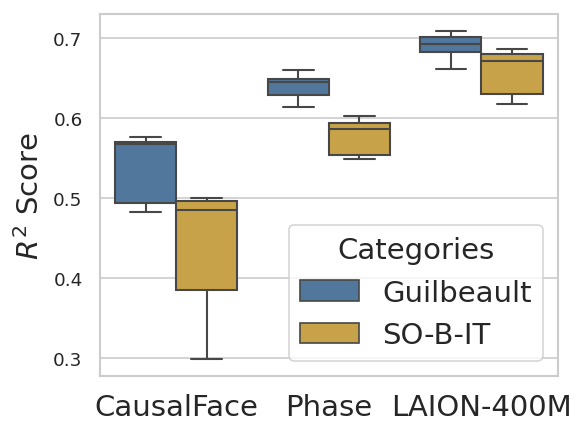

In [13]:
sns.set_context("paper")
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150, tight_layout=True, sharex=True)

palette = ["#4477AA", "#DDAA33"]

sns.boxplot(data=r2_scores_df, x="dataset", y="r2", hue="categories_name", ax=ax, palette=palette)
sns.move_legend(ax, "lower right", title="Categories", title_fontsize=14, fontsize=14)

ax.set_xlabel("")
ax.set_ylabel("$R^2$ Score", fontsize=14)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

plt.savefig("figures/r2_scores_clip_gender.pdf", dpi=300, bbox_inches="tight", format="pdf")
plt.show()